# Variational Autoencoder
Code for re-creating results included in Deep Learning Fall 2017 course report by Niels Jeppesen (niejep/s082927).

VAE implementation can be found in `autoencoder.py`.

In [1]:
%load_ext autoreload
%autoreload 2

import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.layers import Dense, BatchNormalization, Activation, Dropout, Lambda, Input, Conv2D, MaxPooling2D, Conv2DTranspose, UpSampling2D, Reshape, Flatten
from keras.datasets import mnist
from keras.backend import clear_session

from autoencoder import VariationalAutoencoder

Using TensorFlow backend.


Initialize some variables we need.

In [2]:
# Set True to train the models.
TRAIN = False
# Set True to load last weights for each model from input_dir folder.
LOAD_LAST_WEIGHTS = True

input_dir = r'output'

training_epochs = 20
starting_epoch = 0

batch_size = 50

Load MNIST data.

In [3]:
shape = (28,28,1)
size = np.array(shape).prod()
batch_size = 50
training_size = 60000

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train[:training_size] / 255.
x_test = x_test / 255.

Functions for creating layers.

In [4]:
def get_dense_layers(input_dim, intermediate_dim=500, activation='relu'):
    #if TRAIN:
        #clear_session()

    encoder_layers = [
        Dense(intermediate_dim),
        BatchNormalization(),
        Activation(activation),
        Dense(intermediate_dim),
        BatchNormalization(),
        Activation(activation),
    ]

    decoder_layers = [
        Dense(intermediate_dim),
        BatchNormalization(),
        Activation(activation),
        Dense(intermediate_dim),
        BatchNormalization(),
        Activation(activation),
        Dense(input_dim[0], activation='sigmoid', name='decoder_output'),
    ]

    return (encoder_layers, decoder_layers)

def get_conv_dense_layers(input_dim, conv_layers, filters, intermediate_layers, intermediate_dim, pool_size=(2, 2), activation='relu'):
    #if TRAIN:
        #clear_session()

    padding = 'same'

    channels = input_dim[2]
    
    # Calculate upsample shape.
    upsample_shape = (input_dim[0] // (pool_size[0] ** (conv_layers*2)), input_dim[1] // (pool_size[1] ** (conv_layers*2)), filters * (conv_layers))

    encoder_layers = [[
        Conv2D(filters * i, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation(activation),
        Conv2D(filters * i, kernel_size=(3, 3), strides=(2, 2), padding=padding),
        BatchNormalization(),
        Activation(activation),
        MaxPooling2D(pool_size=pool_size)
    ] for i in range(1, conv_layers + 1)]

    encoder_layers += [
        Flatten()
    ]

    encoder_layers += [[
        Dense(intermediate_dim),
        BatchNormalization(),
        Activation(activation),
    ] for _ in range(intermediate_layers)]

    decoder_layers = [[
        Dense(intermediate_dim),
        BatchNormalization(),
        Activation(activation),
    ] for _ in range(intermediate_layers)]

    decoder_layers += [
        Dense(np.product(upsample_shape)),
        BatchNormalization(),
        Activation(activation),
        Reshape(upsample_shape)
    ]

    decoder_layers += [[
        UpSampling2D(pool_size),
        Conv2DTranspose(filters * i, kernel_size=(3, 3), strides=(2, 2), padding='same'),
        BatchNormalization(),
        Activation(activation),
        Conv2DTranspose(filters * i, kernel_size=(3, 3), padding=padding),
        BatchNormalization(),
        Activation(activation),
    ] for i in range(conv_layers, 0, -1)]

    decoder_layers += [
        Conv2DTranspose(channels, kernel_size=(3, 3), activation='sigmoid', padding=padding, name='decoder_output')
    ]

    return (encoder_layers, decoder_layers)

def get_conv_layers(input_dim, conv_layers, filters, pool_size=(2, 2), activation='relu'):
    #if TRAIN:
        #clear_session()

    padding = 'valid'

    encoder_layers = [[
        Conv2D(filters * i, kernel_size=(3, 3), padding='same'),
        BatchNormalization(),
        Activation(activation),
        Conv2D(filters * i, kernel_size=(3, 3), strides=(2, 2), padding=padding),
        BatchNormalization(),
        Activation(activation),
        MaxPooling2D(pool_size=pool_size)
    ] for i in range(1, conv_layers + 1)]

    decoder_layers = [[
        UpSampling2D(pool_size),
        Conv2DTranspose(filters * i, kernel_size=(3, 3), strides=(2, 2), padding='same'),
        BatchNormalization(),
        Activation(activation),
        Conv2DTranspose(filters * i, kernel_size=(3, 3), padding=padding),
        BatchNormalization(),
        Activation(activation),
    ] for i in range(conv_layers, 0, -1)]

    decoder_layers += [
        Conv2DTranspose(input_dim[-1], kernel_size=(3, 3), activation='sigmoid', padding=padding, name='decoder_output')
    ]

    return (encoder_layers, decoder_layers)


Functions for creating the VAEs.

In [5]:
def create_dense_vae(z_dim):
    input_dim = (size,)
    
    encoder_layers, decoder_layers = get_dense_layers(input_dim)
    
    autoencoder = VariationalAutoencoder(input_dim, encoder_layers, decoder_layers, 
                                         z_dim=z_dim, model_name='MNIST_Dense_VAE_z' + str(z_dim))
    
    return autoencoder

def create_conv_dense_vae(z_dim):
    input_dim = shape
    
    encoder_layers, decoder_layers = get_conv_dense_layers(input_dim, conv_layers=1, filters=30, 
                                                           intermediate_layers=1, intermediate_dim=500)
    
    autoencoder = VariationalAutoencoder(input_dim, encoder_layers, decoder_layers, 
                                         z_dim=z_dim, model_name='MNIST_Conv_Dense_VAE_z' + str(z_dim))
    
    return autoencoder
    
def create_conv_vae(z_dim):
    input_dim = shape
    
    encoder_layers, decoder_layers = get_conv_layers(input_dim, conv_layers=2, filters=30)
    
    autoencoder = VariationalAutoencoder(input_dim, encoder_layers, decoder_layers, 
                                         z_dim=z_dim, model_name='MNIST_Conv_VAE_z' + str(z_dim))
    
    return autoencoder


Create function to use for loading weights and training.

In [6]:
def fit(model, x_train, x_test, batch_size=50):

    x_train = x_train.reshape(x_train.shape[:1] + model.input_shape[1:])
    x_test = x_test.reshape(x_test.shape[:1] + model.input_shape[1:])
    
    if LOAD_LAST_WEIGHTS:
        glob_path = ('\\'.join(model.checkpoint_callback.filepath
                                           .split('\\')[:2]) + '\\**\\*weights.*.hdf5').replace('output', input_dir)
        weight_paths = glob.glob(glob_path, recursive=True)
        print('Looking for weights in "%s".' % (glob_path))

        if weight_paths:
            newest_weights = weight_paths[-1]
            
            print('Loading weights from "%s".' % (newest_weights))
            
            model.load_weights(newest_weights)

            weights.append(newest_weights)

    if not TRAIN:
        return

    # If 0, not histogram data is saved. Change to save Tensorboard histograms.
    model.tensorboard_callback.histogram_freq = 0
    
    # Don't write graph because we have all graphs build at once and it's a mess.
    model.tensorboard_callback.write_graph = False
    
    # Print summaries to console.
    model.encoder.summary()
    model.decoder.summary()
    model.summary()

    # Save summary.
    model.save_summary([model.encoder, model.decoder])

    history.append(model.fit(
        x_train, 
        x_train, 
        batch_size=batch_size, 
        epochs=starting_epoch + training_epochs,
        initial_epoch=starting_epoch,
        validation_data=(x_test, x_test),
        callbacks=[model.tensorboard_callback, model.checkpoint_callback]))

### Instantiate models

In [7]:
# Clear TF graph.
clear_session()

models = []

for z_dim in [2, 20, 100]:
    dense = create_dense_vae(z_dim)
    conv_dense = create_conv_dense_vae(z_dim)
    conv = create_conv_vae(z_dim)
    
    models.append(dense)
    models.append(conv_dense)    
    models.append(conv)

## Load and/or train models
Fit models by training and/or loading weights.
To monitor training with Tensorboard type `tensorboard --logdir=output` in console while in the repository root folder.

In [8]:
weights = []
history = []

for model in models:
    fit(model, x_train, x_test, batch_size)

Looking for weights in "output\MNIST_Dense_VAE_z2\**\*weights.*.hdf5".
Loading weights from "output\MNIST_Dense_VAE_z2\20180103-154135\models\20180103-154135.weights.00019-146.17.hdf5".
Looking for weights in "output\MNIST_Conv_Dense_VAE_z2\**\*weights.*.hdf5".
Loading weights from "output\MNIST_Conv_Dense_VAE_z2\20180103-154136\models\20180103-154136.weights.00019-145.01.hdf5".
Looking for weights in "output\MNIST_Conv_VAE_z2\**\*weights.*.hdf5".
Loading weights from "output\MNIST_Conv_VAE_z2\20180103-154138\models\20180103-154138.weights.00019-145.22.hdf5".
Looking for weights in "output\MNIST_Dense_VAE_z20\**\*weights.*.hdf5".
Loading weights from "output\MNIST_Dense_VAE_z20\20180103-154138\models\20180103-154138.weights.00019-99.86.hdf5".
Looking for weights in "output\MNIST_Conv_Dense_VAE_z20\**\*weights.*.hdf5".
Loading weights from "output\MNIST_Conv_Dense_VAE_z20\20180103-154140\models\20180103-154140.weights.00019-97.66.hdf5".
Looking for weights in "output\MNIST_Conv_VAE_z20\

### Training plots
We can load the training data from the Tensorflow summaries and plot them.

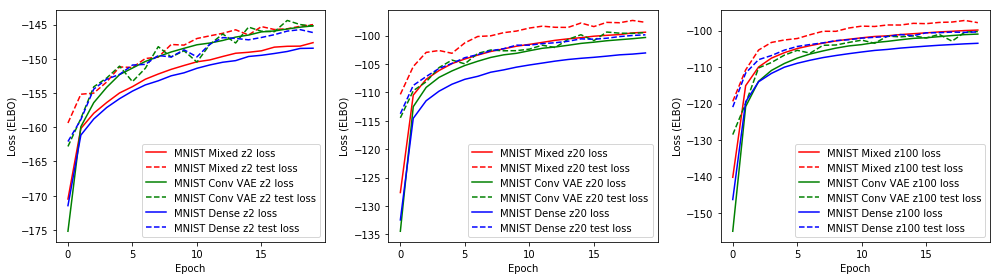

In [9]:
root_paths = [
    r'MNIST*z2\**\events.out.tfevents*',
    r'MNIST*z20\**\events.out.tfevents*',
    r'MNIST*z100\**\events.out.tfevents*',
]

plt.figure(figsize=(14,4))
n = 1

for root_path in root_paths:
    root_path = os.path.join(input_dir, root_path)
    
    paths = glob.glob(root_path, recursive=True)
    model_names = []
    ax = plt.subplot(len(root_paths) // 3, 3, n)

    for path in paths:
        model = path.split('output')[1].split('\\')[1]
        data = {}
        

        for e in tf.train.summary_iterator(path):
            for v in e.summary.value:
                if v.tag == 'loss' or v.tag == 'val_loss':
                    if v.tag not in data:
                        data[v.tag] = []

                    data[v.tag].append(-v.simple_value)

        color = 'r' if 'Conv_Dense' in model else 'b' if 'Dense' in model else 'g'

        ax.plot(data['loss'], color + '-')
        ax.plot(data['val_loss'], color + '--')
        model_names.append(model + '_loss')
        model_names.append(model + '_val_loss')

    for i in range(len(model_names)):
        model_names[i] = model_names[i].replace('3Conv_VAE', 'Conv')
        model_names[i] = model_names[i].replace('2Conv_VAE', 'Conv')
        model_names[i] = model_names[i].replace('Conv_Dense_VAE', 'Mixed')
        model_names[i] = model_names[i].replace('Dense_VAE', 'Dense')

        model_names[i] = model_names[i].replace('_', ' ')
        model_names[i] = model_names[i].replace('val', 'test')
        model_names[i] = model_names[i].replace('UT Conv z2', 'UT Conv z3x2')
        model_names[i] = model_names[i].replace('UT Conv z100', 'UT Conv z3x100')
        
    ax.legend(model_names, loc='lower right')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss (ELBO)')

    # if 'MNIST' in model_names[0]:
    #     plt.axis([0,20,-115,-95])
    # else:
    #     plt.axis([0,20,-8450,-8380])

    #tickpos = [0,5,10,15,20]
    #ax.set_xticks(tickpos)
    
    n = n + 1
    
plt.tight_layout()
plt.show()

## Scatter plots and grid samples
For the two-dimensional latent spaces, we can plot the 10,000 encoded test samples. We've furthermore added 100 points in a grid structure, when we've also reconstructed, to show when the reconstructions from different parts of the latent space looks like.

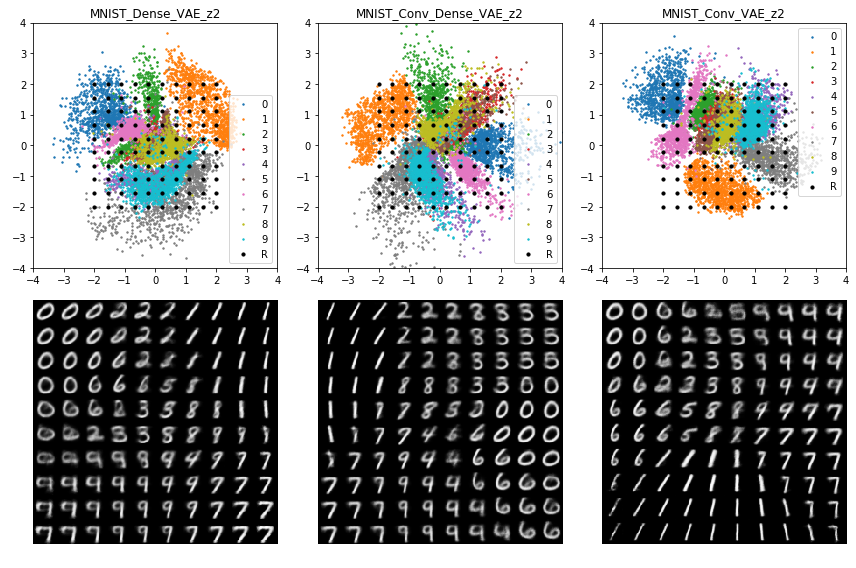

In [10]:
plt.figure(figsize=(12,8))
n = 1
for model in models:

    if model.encoder.output_shape[-1] != 2:
        continue
    
    x_train = x_train.reshape(x_train.shape[:1] + model.input_shape[1:])
    x_test = x_test.reshape(x_test.shape[:1] + model.input_shape[1:])

    x_test_encoded = model.encoder.predict(x_test)
    x_test_encoded = x_test_encoded.reshape(-1,2)
    
    ax = plt.subplot(2, 3, n)
    
    for i in range(10):
        indecies = np.where(y_test==i)[0]
        samples = x_test_encoded[indecies]
        plt.scatter(samples[:, 0], samples[:, 1], label=i, s=2)

    samples = np.zeros((100,2))
    walk_img = np.zeros((10,10,) + shape[:-1])
    for i in range(100):
        r = i // 10
        c = i % 10
        samples[i,0] = -2 + 4/9 * c
        samples[i,1] = 2 - 4/9 * r

    ax.scatter(samples[:, 0], samples[:, 1], c='black', label='R', s=10)
    ax.set_title(model.name)
    ax.legend()
    ax.axis([-4,4,-4,4])
    
    samples = samples.reshape(samples.shape[:1] + model.decoder.input_shape[1:])

    decoded =  model.decoder.predict(samples).reshape((10,10) + shape[:-1])
    walk_img = np.concatenate(np.concatenate(decoded, axis=1), axis=1)

    ax = plt.subplot(2, 3, 3 + n)
    ax.imshow(walk_img, cmap='gray')
    ax.axis('off')
    
    n = n + 1

plt.tight_layout()
plt.show()


## Random walk
For all the models we can do a random walk in the latent space, starting at an encoded digit from the test set. As we move around the space we see how well the decoder generates realistic samples.

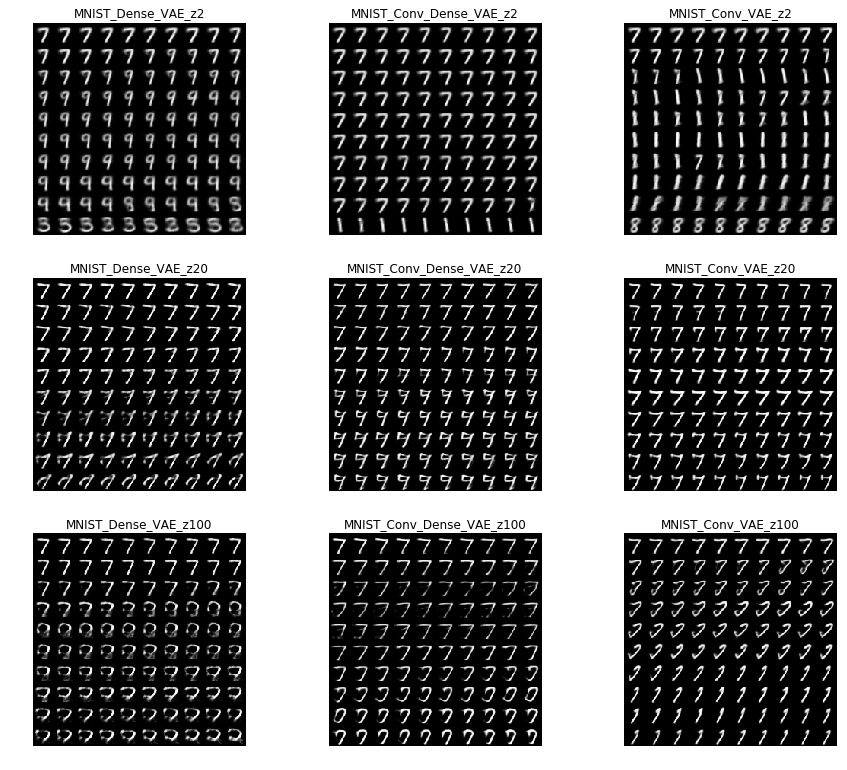

In [11]:
# Random walk
def random_walk(encoded):
    noise = np.random.normal(0, .15, encoded.shape)
    return np.clip(encoded + noise, -2, 2)


plt.figure(figsize=(15,2*len(models)))
n = 1
for model in models:

    x_train = x_train.reshape(x_train.shape[:1] + model.input_shape[1:])
    x_test = x_test.reshape(x_test.shape[:1] + model.input_shape[1:])

    idx = 0
    encoded = model.encoder.predict([x_test[idx:idx+1]])
    random_walk_img = np.zeros((10,10) + shape[:-1])

    ax = plt.subplot(len(models) // 3 + 1, 3, n)

    np.random.seed(42)
    for i in range(100):
        r = i // 10
        c = i % 10

        decoded = model.decoder.predict([encoded])
        random_walk_img[r,c] = decoded.reshape(shape[:-1])
        encoded = random_walk(encoded)

    random_walk_img = np.concatenate(np.concatenate(random_walk_img, axis=1), axis=1)

    ax.axis('off')
    ax.set_title(model.name)
    ax.imshow(random_walk_img, cmap='gray')
    
    n = n + 1
    
plt.show()

## Anomaly detection
We can find the 100 test samples with the highest loss (lowest ELBO) and shown them, their reconstructions and a histogram for the classes.

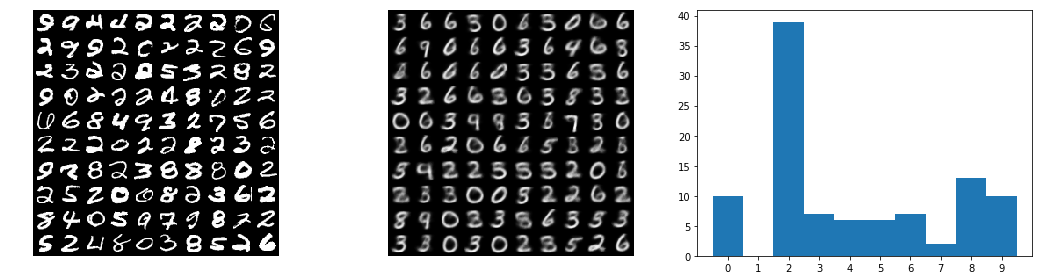

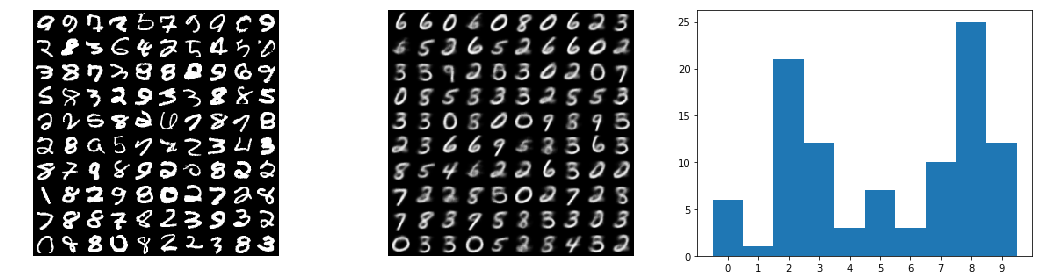

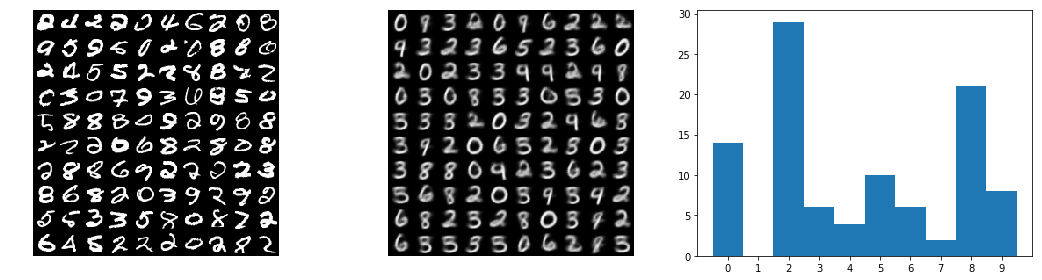

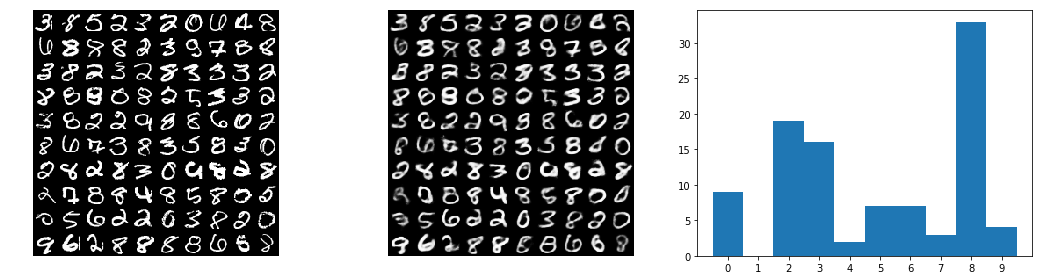

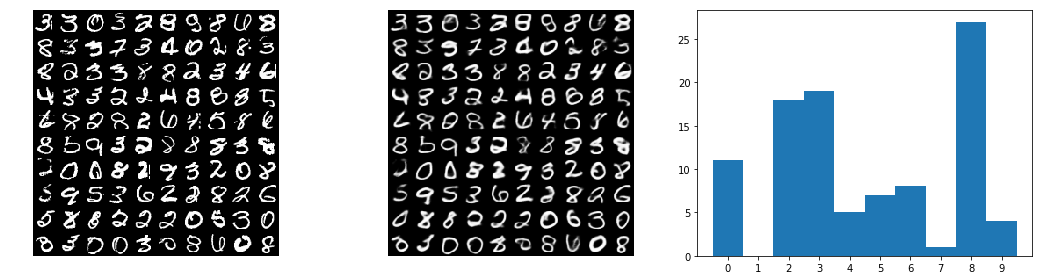

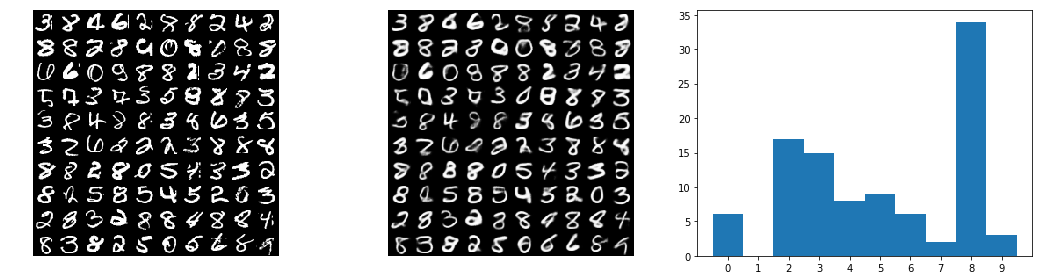

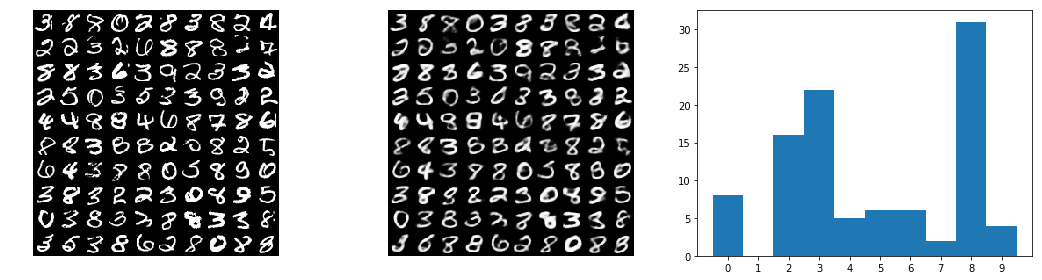

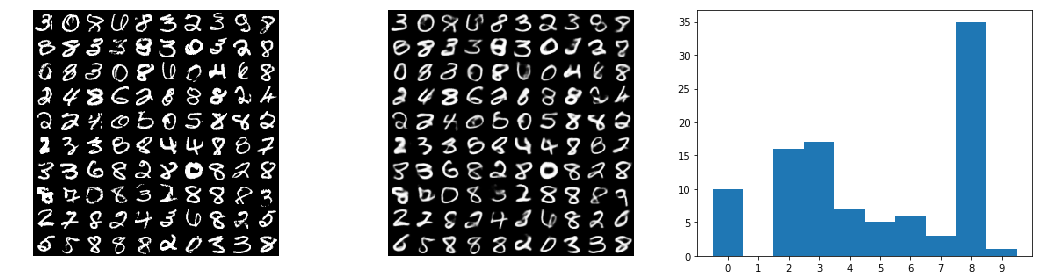

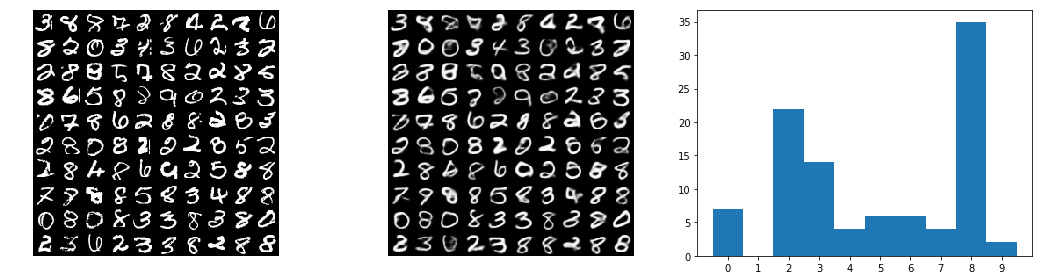

In [12]:
for model in models:
  
    x_train = x_train.reshape(x_train.shape[:1] + model.input_shape[1:])
    x_test = x_test.reshape(x_test.shape[:1] + model.input_shape[1:])

    predicted = model.predict(x_test)

    x_test_losses = np.asarray([model.evaluate(x_test[i:i+1],x_test[i:i+1],verbose=0) for i in range(len(x_test))])
    
    n = 100
    top_losses = x_test_losses[:,0].argsort()[-n:][::-1]
    bottom_losses = x_test_losses[:,0].argsort()[:n][::-1]

    top_losses_img = np.zeros((10,10) + shape[:-1])
    top_losses_pred_img = np.zeros((10,10) + shape[:-1])
    
    for i, idx in enumerate(top_losses):
        r = i // 10
        c = i % 10

        top_losses_img[r,c] = x_test[idx].reshape(shape[:-1])
        top_losses_pred_img[r,c] = predicted[idx].reshape(shape[:-1])

    top_losses_img = np.concatenate(np.concatenate(top_losses_img, axis=1), axis=1)
    top_losses_pred_img = np.concatenate(np.concatenate(top_losses_pred_img, axis=1), axis=1)

    plt.figure(figsize=(15,4))
    ax = plt.subplot(1, 3, 1)
    ax.axis('off')
    ax.imshow(top_losses_img, cmap='gray')
    
    ax = plt.subplot(1, 3, 2)
    ax.axis('off')
    ax.imshow(top_losses_pred_img, cmap='gray')
    
    ax = plt.subplot(1, 3, 3)
    ax.set_xticks(range(10))
    ax.hist(np.take(y_test, top_losses), bins=range(11), align='left')

    plt.tight_layout()
    plt.show()